# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import operator
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def copy_df(input_df):
    """ copy dataframe and reset index """
    
    output_df = input_df.copy().reset_index(drop=True)
    return output_df

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_azdias_subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data
azdias = pd.read_csv('udacity_azdias_subset.csv', delimiter=';')

# Load in the feature summary file
feat_info = pd.read_csv('azdias_feature_summary.csv', delimiter=';')

> Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows)

In [4]:
# check rows and columns for azdias df
rows, cols = azdias.shape
print('----- azdias dataframe -----')
print(f'number of rows: {rows}')
print(f'number of columns: {cols}')

----- azdias dataframe -----
number of rows: 891221
number of columns: 85


In [5]:
# check data types for azdias df
azdias.dtypes

AGER_TYP                  int64
ALTERSKATEGORIE_GROB      int64
ANREDE_KZ                 int64
CJT_GESAMTTYP           float64
FINANZ_MINIMALIST         int64
                         ...   
PLZ8_HHZ                float64
PLZ8_GBZ                float64
ARBEIT                  float64
ORTSGR_KLS9             float64
RELAT_AB                float64
Length: 85, dtype: object

In [6]:
# take a look at first few records of azdias df
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# take a look at first few records of feat_info
feat_info.head

<bound method NDFrame.head of                attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]>

In [8]:
def convert_to_na(dataframe):
    """ Convert missing or unknown data values to NaN """
    
    df = copy_df(dataframe)
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    for attr, nan_vals in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if nan_vals[0] != '':
            for val in nan_vals:
                if val.isnumeric() or val.lstrip('-').isnumeric():
                    val = int(val)
                df.loc[df[attr] == val, attr] = np.nan

    return df

In [9]:
# Identify missing or unknown data values and convert them to NaNs
azdias = convert_to_na(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

> Perform an assessment of how much missing data there is in each column of the dataset.

In [10]:
# create new df with feature name and count of missing values
na_azdias = azdias.isna().sum().reset_index()
na_azdias.rename({'index': 'feat', 0: 'count'}, axis='columns', inplace=True)
na_azdias.sort_values(by='count', ascending=False, inplace=True)
print(na_azdias.head(10))

              feat   count
40        TITEL_KZ  889061
0         AGER_TYP  685843
47    KK_KUNDENTYP  584612
64    KBA05_BAUMAX  476524
11     GEBURTSJAHR  392318
43        ALTER_HH  310267
70             KKK  158064
73        REGIOTYP  158064
48  W_KEIT_KIND_HH  147988
60     KBA05_ANTG1  133324


<function matplotlib.pyplot.show(close=None, block=None)>

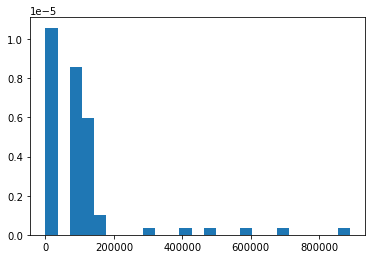

In [11]:
# using hist function to identify outliers
histogram = plt.hist(na_azdias['count'], 25, density=1)
plt.show

It's a bit hard to see, so let's try again after removing features with no missing values

<function matplotlib.pyplot.show(close=None, block=None)>

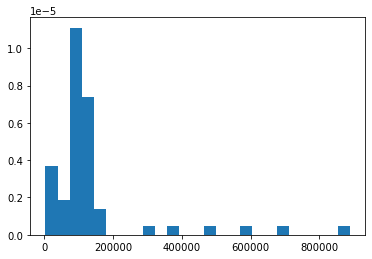

In [12]:
na_azdias_hist = na_azdias.loc[(na_azdias['count'] > 0)]
histogram = plt.hist(na_azdias_hist['count'], 25, density=1)
plt.show

If we use a boxplot instead, we don't need to remove records to output a clean visualization

<AxesSubplot:xlabel='count'>

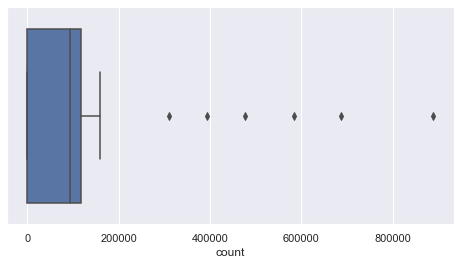

In [13]:
# using seaborn boxplot to identify outliers
sns.set(rc = {'figure.figsize':(8,4)})
sns.boxplot(x=na_azdias['count'])

It looks like there are six outliers - I'll remove those from the azdias dataset at a later step

In [14]:
print(na_azdias.head(6))

# create list of outliers
outliers = []
for i in range(0,6):
    outliers.append(na_azdias.iloc[i]['feat'])
print(f'\nList of outliers to remove: {outliers}')

            feat   count
40      TITEL_KZ  889061
0       AGER_TYP  685843
47  KK_KUNDENTYP  584612
64  KBA05_BAUMAX  476524
11   GEBURTSJAHR  392318
43      ALTER_HH  310267

List of outliers to remove: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


> Investigate patterns in the amount of missing data in each column.

In [15]:
# copy df with count of missing
missing = copy_df(na_azdias)
missing.rename({'count': 'cnt_na'}, axis='columns', inplace=True)
print(missing.head(10))

             feat  cnt_na
0        TITEL_KZ  889061
1        AGER_TYP  685843
2    KK_KUNDENTYP  584612
3    KBA05_BAUMAX  476524
4     GEBURTSJAHR  392318
5        ALTER_HH  310267
6             KKK  158064
7        REGIOTYP  158064
8  W_KEIT_KIND_HH  147988
9     KBA05_ANTG1  133324


In [16]:
# add count of not missing
missing['cnt_not_na'] = missing['cnt_na'].max() - missing['cnt_na']
print(missing.head(10))

             feat  cnt_na  cnt_not_na
0        TITEL_KZ  889061           0
1        AGER_TYP  685843      203218
2    KK_KUNDENTYP  584612      304449
3    KBA05_BAUMAX  476524      412537
4     GEBURTSJAHR  392318      496743
5        ALTER_HH  310267      578794
6             KKK  158064      730997
7        REGIOTYP  158064      730997
8  W_KEIT_KIND_HH  147988      741073
9     KBA05_ANTG1  133324      755737


In [17]:
# add percent of missing values
missing['pct_na'] = round(missing['cnt_na'] / missing['cnt_na'].max(), 4)
print(missing.head(10))

             feat  cnt_na  cnt_not_na  pct_na
0        TITEL_KZ  889061           0  1.0000
1        AGER_TYP  685843      203218  0.7714
2    KK_KUNDENTYP  584612      304449  0.6576
3    KBA05_BAUMAX  476524      412537  0.5360
4     GEBURTSJAHR  392318      496743  0.4413
5        ALTER_HH  310267      578794  0.3490
6             KKK  158064      730997  0.1778
7        REGIOTYP  158064      730997  0.1778
8  W_KEIT_KIND_HH  147988      741073  0.1665
9     KBA05_ANTG1  133324      755737  0.1500


<function matplotlib.pyplot.show(close=None, block=None)>

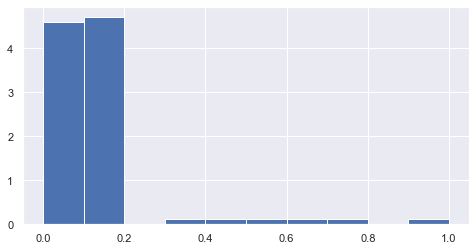

In [18]:
# Most of the features are missing between 0% and 25% of their values
fig = plt.hist(missing['pct_na'], 10, density=1)
plt.show

In [19]:
# create subset of missing df with records missing 1% through 25% of values
missing_25 = copy_df(missing)
mask = ((missing_25['pct_na'] <= 0.25) & (missing_25['pct_na'] > 0))
missing_25 = missing_25.loc[mask]

<function matplotlib.pyplot.show(close=None, block=None)>

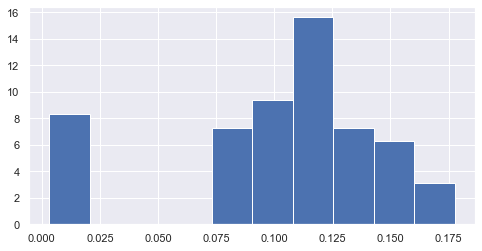

In [20]:
# plot new subset
histogram = plt.hist(missing_25['pct_na'], 10, density=1)
plt.show

> Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

In [21]:
# remove outliers from azdias df using outliers list created above
azdias.drop(labels=outliers, axis=1, inplace=True)
print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

While most features were missing between 0% and 25% of their data, there were a few notable outliers:

|      Feature 	| Percent Missing 	|
|-------------:	|-----------------	|
|     TITEL_KZ 	|            100% 	|
|     AGER_TYP 	|             77% 	|
| KK_KUNDENTYP 	|             66% 	|
| KBA05_BAUMAX 	|             54% 	|
|  GEBURTSJAHR 	|             44% 	|
|     ALTER_HH 	|             35% 	|

In [22]:
# outliers dataframe
missing[missing.feat.isin(outliers)]

,feat,cnt_na,cnt_not_na,pct_na
0,TITEL_KZ,889061,0,1.0000
1,AGER_TYP,685843,203218,0.7714
2,KK_KUNDENTYP,584612,304449,0.6576
3,KBA05_BAUMAX,476524,412537,0.5360
4,GEBURTSJAHR,392318,496743,0.4413
5,ALTER_HH,310267,578794,0.3490


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

#### How much data is missing in each row of the dataset?

In [23]:
# add columns to azdias df with count of missing row values and percent missing
azdias['cnt_na_rows'] = len(azdias.columns) - azdias.count(axis=1)
azdias['pct_na_rows'] = azdias['cnt_na_rows'] / len(azdias.columns)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,cnt_na_rows,pct_na_rows
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,0.5375
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0.0000
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0.0000
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7,0.0875
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0.0000


<function matplotlib.pyplot.show(close=None, block=None)>

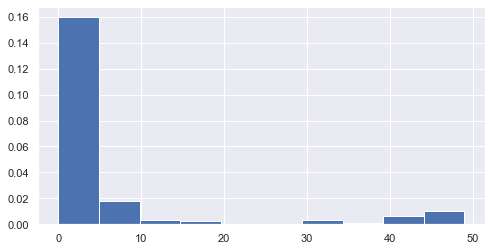

In [24]:
# plot by count of missing values by row
histogram = plt.hist(azdias['cnt_na_rows'], 10, density=1)
plt.show

The vast majority aren't missing any records, let's remove those to analyze the records that do have missing values.

In [25]:
# remove records with no missing values
na_rows = azdias.copy()
na_rows = na_rows[na_rows['cnt_na_rows'] > 0]
print(na_rows.shape)

(268012, 81)


<function matplotlib.pyplot.show(close=None, block=None)>

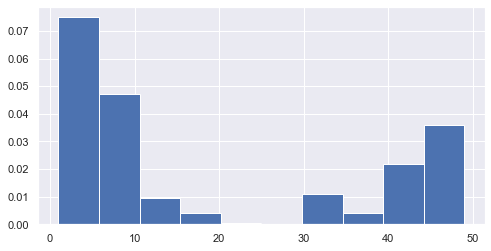

In [26]:
# plot new subset
fig = plt.hist(na_rows['cnt_na_rows'], 10, density=1)
plt.show

> Write code to divide the data into two subsets based on the number of missing values in each row.

There's a clear divide between records missing more than 25, and those missing less than 25

In [27]:
# create two subsets
na_rows_over = na_rows[na_rows['cnt_na_rows'] > 25].copy()
na_rows_under = na_rows[na_rows['cnt_na_rows'] <= 25].copy()

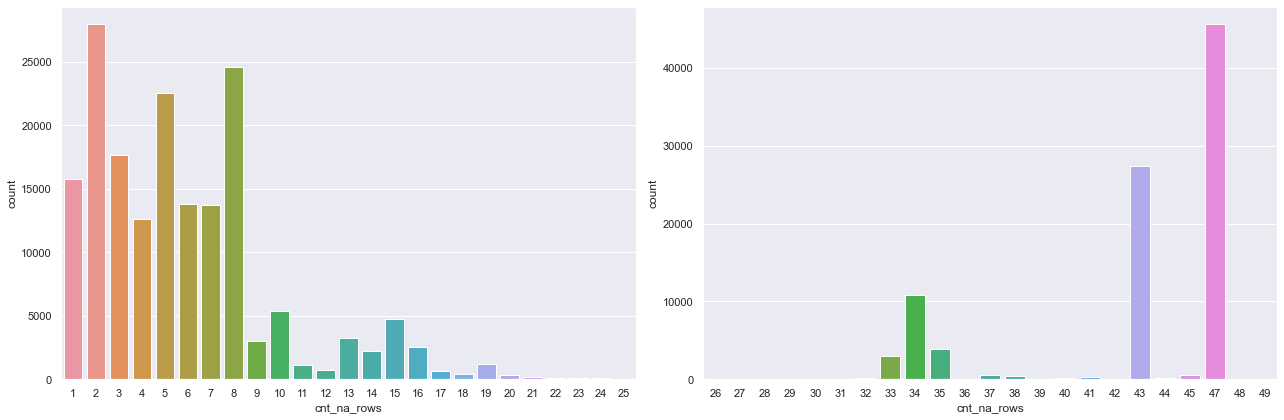

In [28]:
# plot both subsets
fig, (ax_under, ax_over) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(data=na_rows_under, x='cnt_na_rows', ax=ax_under)
sns.countplot(data=na_rows_over, x='cnt_na_rows', ax=ax_over)
plt.tight_layout()

> Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

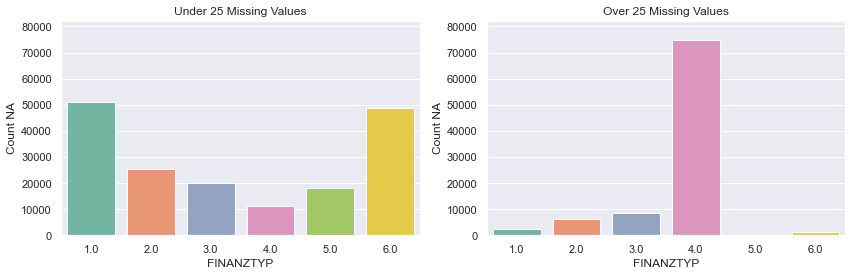

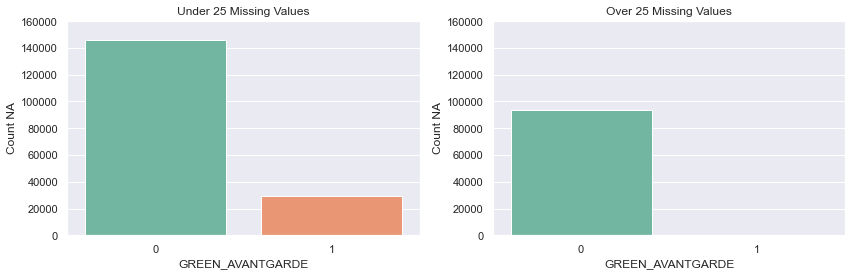

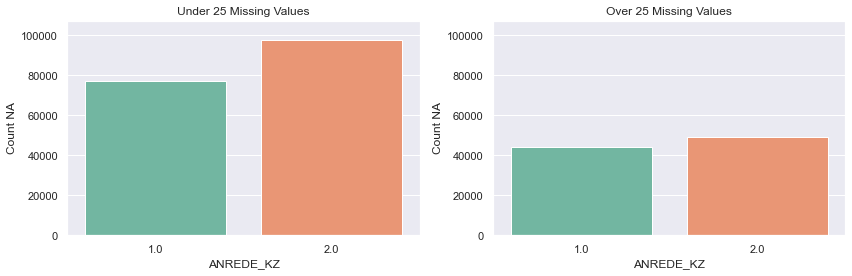

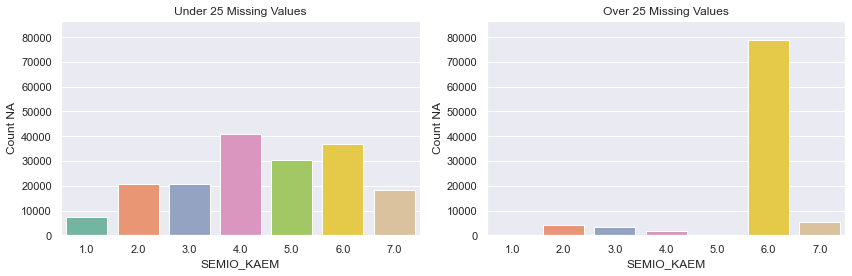

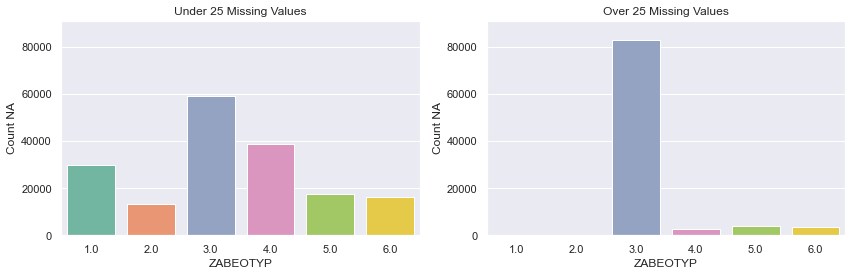

In [29]:
clean_cols = ['FINANZTYP', 'GREEN_AVANTGARDE', 'ANREDE_KZ', 'SEMIO_KAEM', 'ZABEOTYP']

for col in clean_cols:
    lim = (max(na_rows_under[col].value_counts().iloc[0], na_rows_over[col].value_counts().iloc[0])) * 1.1
    lab = 'Count NA'
    title_under = 'Under 25 Missing Values'
    title_over = 'Over 25 Missing Values'
    fig, (ax_under, ax_over) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(data=na_rows_under, x=col, ax=ax_under, palette='Set2')
    ax_under.set_ylabel(lab)
    ax_under.set_ylim(top=lim)
    ax_under.set_title(title_under)

    sns.countplot(data=na_rows_over, x=col, ax=ax_over, palette='Set2')
    ax_over.set_ylabel(lab)
    ax_over.set_ylim(top=lim)
    ax_over.set_title(title_over)
    
    plt.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row

It looks like there is a pattern emerging for records with over 25 missing values. In three of the example features selected (FINANZTYP, SEMIO_KAEM, ZABEOTYP) the responses associated with missing feature values are evenly distributed. However, if we look at the chart for records with more than 25 missing feature values, in each example there is one response that stands out as a possible predictor for other missing feature values.

We probably want to remove some portion of those records with a lot of missing feature values from the rest of our analysis.

In [30]:
# check percentage of df that has more than 25 missing values
pct_over_25 = round((len(na_rows_over) / len(azdias))*100, 2)
print(f'Percentage of azdias df with more than 25 missing feature values: {pct_over_25}%')

Percentage of azdias df with more than 25 missing feature values: 10.46%


In [31]:
# prep subset
azdias_og = copy_df(azdias)
azdias = copy_df(na_rows_over)
azdias.drop(['cnt_na_rows', 'pct_na_rows'], inplace=True, axis=1)
print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

> How many features are there of each data type?

In [32]:
# first let's remove the outlier columns from feat_info
feat_info = feat_info.set_index('attribute').drop(outliers).reset_index()

In [33]:
# check current data types
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

> Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [34]:
def list_cols_by_type(input_type):
    lst = feat_info[feat_info.type == input_type]
    lst = lst['attribute'].unique()
    print(f'\nFeatures with data type {input_type}: \n {lst}')
    print()
    return lst

In [35]:
def unique_vals_by_col(data, col_list):
    columns = sorted(col_list)
    for col in columns:
        vals = list(data[col].unique())
        print(f'{col}: {vals}')

In [36]:
# get lists of categorical features
categorical_cols = list_cols_by_type('categorical')


Features with data type categorical: 
 ['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']



In [37]:
# take a look at the values for categorical features
unique_vals_by_col(azdias, categorical_cols)

ANREDE_KZ: [1.0, 2.0]
CAMEO_DEUG_2015: [nan, '4', '8', '3', '2', '5', '9', '6']
CAMEO_DEU_2015: [nan, '4E', '8A', '3B', '2C', '2B', '3C', '4C', '5A', '9E', '3A', '4A', '3D', '2A', '8C', '6A']
CJT_GESAMTTYP: [2.0, 6.0, 3.0, 4.0, 5.0, 1.0, nan]
FINANZTYP: [4.0, 3.0, 1.0, 2.0, 6.0, 5.0]
GEBAEUDETYP: [nan, 1.0, 2.0, 3.0, 6.0, 8.0, 4.0]
GFK_URLAUBERTYP: [10.0, 5.0, 11.0, 7.0, 1.0, 9.0, 8.0, 12.0, nan, 2.0, 4.0, 6.0, 3.0]
GREEN_AVANTGARDE: [0, 1]
LP_FAMILIE_FEIN: [2.0, nan, 1.0, 10.0, 3.0, 9.0, 11.0, 8.0, 5.0, 6.0, 7.0, 4.0]
LP_FAMILIE_GROB: [2.0, nan, 1.0, 5.0, 3.0, 4.0]
LP_STATUS_FEIN: [1.0, 5.0, 4.0, 9.0, 2.0, 6.0, nan, 8.0, 10.0, 3.0, 7.0]
LP_STATUS_GROB: [1.0, 2.0, 4.0, 3.0, nan, 5.0]
NATIONALITAET_KZ: [nan, 1.0, 3.0, 2.0]
OST_WEST_KZ: [nan, 'W', 'O']
SHOPPER_TYP: [nan, 3.0, 1.0, 2.0, 0.0]
SOHO_KZ: [nan, 0.0, 1.0]
VERS_TYP: [nan, 2.0, 1.0]
ZABEOTYP: [3.0, 4.0, 2.0, 1.0, 5.0, 6.0]


**Binary categorical features**
- ANREDE_KZ
- GREEN_AVANTGARDE **
- SOHO_KZ
- VERS_TYP
- OST_WEST_KZ **

**Multi-level categorical features**
- CJT_GESAMTTYP *
- FINANZTYP *
- GFK_URLAUBERTYP *
- LP_FAMILIE_FEIN *
- LP_FAMILIE_GROB *
- LP_STATUS_FEIN *
- LP_STATUS_GROB *
- NATIONALITAET_KZ *
- SHOPPER_TYP *
- ZABEOTYP *
- GEBAEUDETYP *
- CAMEO_DEUG_2015 **
- CAMEO_DEU_2015 **

> Re-encode categorical variable(s) to be kept in the analysis.

In [38]:
# convert GREEN_AVANTGARDE to float
azdias['GREEN_AVANTGARDE'] = azdias['GREEN_AVANTGARDE'].astype(float)
print(azdias['GREEN_AVANTGARDE'].dtype)

float64


In [39]:
# drop CAMEO_DEUG_2015 and CAMEO_DEU_2015
azdias.drop(labels=['CAMEO_DEUG_2015','CAMEO_DEU_2015'], axis=1, inplace=True)
print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05

In [40]:
# map OST_WEST_KZ to numeric
con = [
    azdias['OST_WEST_KZ'] == 'O',
    azdias['OST_WEST_KZ'] == 'W'
]
res = [
    0.0,
    1.0
]

azdias['OST_WEST_KZ'] = np.select(con, res, default=np.nan)
azdias['OST_WEST_KZ'].value_counts()

1.0    95
0.0    17
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

There were two binary categorical features that need to be re-encoded. I'll re-encoded GREEN_AVANTGARDE as a float; this is probably not necessary, but it's a quick fix and could prevent future issues. Also, OST_WEST_KZ needed to be re-encoded as numeric.

I dropped two of the multi-level categorical features (CAMEO_DEUG_2015, CAMEO_DEU_2015) for the sake of simplicity. The remaining multi-level categorical features were added to list of columns that will be one-hot-encoded in a later step.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# get lists of mixed features
mixed_cols = list_cols_by_type('mixed')


Features with data type mixed: 
 ['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']



In [42]:
# take a look at the values for mixed features
unique_vals_by_col(azdias, mixed_cols)

CAMEO_INTL_2015: [nan, '25', '51', '23', '14', '13', '24', '31', '55', '22', '12', '54']
LP_LEBENSPHASE_FEIN: [15.0, nan, 7.0, 19.0, 33.0, 22.0, 1.0, 37.0, 14.0, 6.0, 5.0, 11.0, 30.0, 4.0, 38.0, 29.0, 12.0, 28.0, 32.0, 31.0, 18.0, 24.0, 2.0, 9.0, 13.0, 3.0, 17.0, 27.0, 34.0, 8.0, 40.0, 25.0, 16.0, 21.0, 10.0, 35.0, 39.0, 20.0, 23.0, 26.0, 36.0]
LP_LEBENSPHASE_GROB: [4.0, nan, 2.0, 5.0, 11.0, 6.0, 1.0, 12.0, 3.0, 9.0, 8.0, 10.0, 7.0]
PLZ8_BAUMAX: [nan]
PRAEGENDE_JUGENDJAHRE: [nan, 8.0, 14.0, 3.0, 5.0, 1.0, 10.0, 15.0, 11.0]
WOHNLAGE: [nan, 0.0, 3.0, 5.0, 4.0, 2.0, 7.0, 1.0, 8.0]


In [43]:
def eng_new_feats(data, col):
    df = copy_df(data)

    if col == 'PRAEGENDE_JUGENDJAHRE':
        var1 = 'PRAEGENDE_JUGENDJAHRE_DECADE'
        var2 = 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'

        con1 = [
            df[col] <= 2,
            df[col] <= 4,
            df[col] <= 7,
            df[col] <= 9,
            df[col] <= 13,
            df[col] <= 15
        ]
        res1 = [
            40.0, 50.0, 60.0, 70.0, 80.0, 90.0
        ]

        con2 = [
            df[col].isin([1,3,5,8,10,12,14]),
            df[col].isin([2,4,6,7,9,11,13,15])
        ]
        res2 = [
            0.0, 1.0
        ]

    elif col == 'CAMEO_INTL_2015':
        var1 = 'CAMEO_INTL_2015_WEALTH'
        var2 = 'CAMEO_INTL_2015_LIFESTAGE'

        df[col] = df[col].astype(float)

        con1 = [
            df[col] < 20,
            df[col] < 30,
            df[col] < 40,
            df[col] < 50,
            df[col] < 60
        ]
        res1 = [
            10.0, 20.0, 30.0, 40.0, 50.0
        ]

        con2 = [
            df[col].isin([11,21,31,41,51]),
            df[col].isin([12,22,32,42,52]),
            df[col].isin([13,23,33,43,53]),
            df[col].isin([14,24,34,44,54]),
            df[col].isin([15,25,35,45,55])
        ]
        res2 = [
            1.0, 2.0, 3.0, 4.0, 5.0
        ]

    else:
        print(f'Logic for {col} not defined...')
        return df

    df[var1] = np.select(con1, res1, default=np.nan)
    df[var2] = np.select(con2, res2, default=np.nan)

    print(f'New variables for {col} have been created: {var1}, {var2}')

    return df

##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [44]:
# check counts before creating new variables
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    5729
8.0     4376
5.0     1729
3.0     1354
1.0      604
10.0       8
15.0       4
11.0       1
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [45]:
# create new variables
azdias = eng_new_feats(azdias, 'PRAEGENDE_JUGENDJAHRE')

New variables for PRAEGENDE_JUGENDJAHRE have been created: PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MOVEMENT


In [46]:
# check counts after creating new variables
print(azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts(), '\n')
print(azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts())

90.0    5733
70.0    4376
60.0    1729
50.0    1354
40.0     604
80.0       9
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64 

0.0    13800
1.0        5
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


##### Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [47]:
# check counts before creating new variables
azdias['CAMEO_INTL_2015'].value_counts()

24    6
25    4
23    4
31    4
22    3
14    2
13    2
51    1
55    1
12    1
54    1
Name: CAMEO_INTL_2015, dtype: int64

In [48]:
# create new variables
azdias = eng_new_feats(azdias, 'CAMEO_INTL_2015')

New variables for CAMEO_INTL_2015 have been created: CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFESTAGE


In [49]:
# check counts after creating new variables
print(azdias['CAMEO_INTL_2015_WEALTH'].value_counts(), '\n')
print(azdias['CAMEO_INTL_2015_LIFESTAGE'].value_counts())

20.0    17
10.0     5
30.0     4
50.0     3
Name: CAMEO_INTL_2015_WEALTH, dtype: int64 

4.0    9
3.0    6
5.0    5
1.0    5
2.0    4
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: int64


In [50]:
# drop original mixed type features
azdias.drop(labels=mixed_cols, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I employed the np.select method above to create four new features:
- PRAEGENDE_JUGENDJAHRE_DECADE
- PRAEGENDE_JUGENDJAHRE_MOVEMENT
- CAMEO_INTL_2015_WEALTH
- CAMEO_INTL_2015_LIFESTAGE

I also dropped the mixed type features from our working dataset

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

> If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)

In [51]:
# check ordinal columns
ordinal_cols = list_cols_by_type('ordinal')
unique_vals_by_col(azdias, ordinal_cols)


Features with data type ordinal: 
 ['ALTERSKATEGORIE_GROB' 'FINANZ_MINIMALIST' 'FINANZ_SPARER'
 'FINANZ_VORSORGER' 'FINANZ_ANLEGER' 'FINANZ_UNAUFFAELLIGER'
 'FINANZ_HAUSBAUER' 'HEALTH_TYP' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'HH_EINKOMMEN_SCORE' 'W_KEIT_KIND_HH'
 'WOHNDAUER_2008' 'KONSUMNAEHE' 'KBA05_ANTG1' 'KBA05_ANTG2' 'KBA05_ANTG3'
 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM' 'EWDICHTE' 'INNENSTADT'
 'GEBAEUDETYP_RASTER' 'KKK' 'MOBI_REGIO' 'ONLINE_AFFINITAET' 'REGIOTYP'
 'PLZ8_ANTG1' 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'PLZ8_HHZ' 'PLZ8_GBZ'
 'ARBEIT' 'ORTSGR_KLS9' 'RELAT_AB']

ALTERSKATEGORIE_GROB: [2.0, 3.0, nan, 1.0, 4.0]
ARBEIT: [nan, 4.0, 2.0, 3.0, 1.0, 5.0]
BALLRAUM: [nan, 6.0, 2.0, 5.0, 3.0, 1.0, 4.0, 7.0]
EWDICHTE: [nan, 5.0, 3.0, 6.0, 4.0, 2.0, 1.0]
FINANZ_ANLEGER: [5.0, 4.0, 2.0, 3.0, 1.0]
FINANZ_HAUSBAUER: [3.0, 1.0

In [52]:
# check numeric columns
numeric_cols = list_cols_by_type('numeric')
unique_vals_by_col(azdias, numeric_cols)


Features with data type numeric: 
 ['ANZ_PERSONEN' 'ANZ_TITEL' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'MIN_GEBAEUDEJAHR' 'KBA13_ANZAHL_PKW']

ANZ_HAUSHALTE_AKTIV: [nan, 1.0, 30.0, 3.0, 5.0, 6.0, 2.0, 13.0, 23.0, 9.0, 7.0, 10.0, 4.0, 56.0, 8.0, 11.0]
ANZ_HH_TITEL: [nan, 0.0, 1.0]
ANZ_PERSONEN: [nan, 1.0, 2.0, 7.0, 3.0, 4.0, 5.0, 0.0, 6.0, 10.0, 9.0, 8.0, 29.0]
ANZ_TITEL: [nan, 0.0, 1.0, 2.0]
KBA13_ANZAHL_PKW: [nan, 739.0, 1231.0, 480.0, 85.0, 707.0, 553.0, 786.0, 791.0, 539.0]
MIN_GEBAEUDEJAHR: [nan, 2014.0, 2011.0, 2012.0, 2015.0, 1999.0, 2013.0, 2002.0, 2016.0, 2004.0, 2005.0, 1994.0, 2009.0, 1997.0, 2006.0, 2008.0, 2010.0, 2000.0, 2001.0, 2007.0]


A few of the numeric columns are a bit broad. I'll create groups to clean them up.

In [53]:
def grp_num_cols(data, col):
    df = copy_df(data)
    
    if col == 'ANZ_PERSONEN':
        con = [
            df[col] >= 10.0,
            df[col] >= 5.0,
            df[col] == 0.0,
            df[col] == 1.0,
            df[col] == 2.0,
            df[col] == 3.0,
            df[col] == 4.0
        ]
        res = [
            10.0, 5.0, 0.0, 1.0, 2.0, 3.0, 4.0
        ]

    elif col == 'ANZ_TITEL':
        con = [
            df[col] >= 10.0,
            df[col] >= 5.0,
            df[col] == 0.0,
            df[col] == 1.0,
            df[col] == 2.0,
            df[col] == 3.0,
            df[col] == 4.0
        ]
        res = [
            10.0, 5.0, 0.0, 1.0, 2.0, 3.0, 4.0
        ]

    elif col == 'ANZ_HAUSHALTE_AKTIV':
        con = [
            df[col] >= 20.0,
            df[col] >= 15.0,
            df[col] >= 10.0,
            df[col] >= 5.0,
            df[col] >= 1.0,
            df[col] == 0.0,
        ]
        res = [
            20.0, 15.0, 10.0, 5.0, 1.0, 0.0
        ]

    elif col == 'ANZ_HH_TITEL':
        con = [
            df[col] == 0.0,
            df[col] == 1.0,
            df[col] >= 2.0
        ]
        res = [
            0.0, 1.0, 2.0
        ]

    elif col == 'MIN_GEBAEUDEJAHR':
        con = [
            df[col] >= 2015.0,
            df[col] >= 2010.0,
            df[col] >= 2005.0,
            df[col] >= 2000.0,
            df[col] == 0.0,
            df[col] <= 1999.0
        ]
        res = [
            2015.0, 2010.0, 2005.0, 2000.0, 0.0, 1999.0
        ]

    elif col == 'KBA13_ANZAHL_PKW':
        con = [
            df[col] >= 1000.0,
            df[col] >= 900.0,
            df[col] >= 800.0,
            df[col] >= 700.0,
            df[col] >= 600.0,
            df[col] >= 500.0,
            df[col] >= 400.0,
            df[col] >= 300.0,
            df[col] >= 200.0,
            df[col] >= 100.0,
            df[col] >= 1.0
        ]
        res = [
            1000.0, 900.0, 800.0, 700.0, 600.0, 500.0, 
            400.0, 300.0, 200.0, 100.0, 1.0
        ]

    else:
        print(f'Logic for {col} not defined...')
        return df

    df[col] = np.select(con, res, default=np.nan)
    print(f'Values for {col} have been grouped...')

    return df

In [54]:
# group numeric columns
cols = [
    'ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV', 
    'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW'
]

for c in cols:
    azdias = grp_num_cols(azdias, c)

Values for ANZ_PERSONEN have been grouped...
Values for ANZ_TITEL have been grouped...
Values for ANZ_HAUSHALTE_AKTIV have been grouped...
Values for ANZ_HH_TITEL have been grouped...
Values for MIN_GEBAEUDEJAHR have been grouped...
Values for KBA13_ANZAHL_PKW have been grouped...


In [55]:
# create column list and check values
azdias_cols = list(azdias.columns)
print(unique_vals_by_col(azdias, azdias_cols))

ALTERSKATEGORIE_GROB: [2.0, 3.0, nan, 1.0, 4.0]
ANREDE_KZ: [1.0, 2.0]
ANZ_HAUSHALTE_AKTIV: [nan, 1.0, 20.0, 5.0, 10.0]
ANZ_HH_TITEL: [nan, 0.0, 1.0]
ANZ_PERSONEN: [nan, 1.0, 2.0, 5.0, 3.0, 4.0, 0.0, 10.0]
ANZ_TITEL: [nan, 0.0, 1.0, 2.0]
ARBEIT: [nan, 4.0, 2.0, 3.0, 1.0, 5.0]
BALLRAUM: [nan, 6.0, 2.0, 5.0, 3.0, 1.0, 4.0, 7.0]
CAMEO_INTL_2015_LIFESTAGE: [nan, 5.0, 1.0, 3.0, 4.0, 2.0]
CAMEO_INTL_2015_WEALTH: [nan, 20.0, 50.0, 10.0, 30.0]
CJT_GESAMTTYP: [2.0, 6.0, 3.0, 4.0, 5.0, 1.0, nan]
EWDICHTE: [nan, 5.0, 3.0, 6.0, 4.0, 2.0, 1.0]
FINANZTYP: [4.0, 3.0, 1.0, 2.0, 6.0, 5.0]
FINANZ_ANLEGER: [5.0, 4.0, 2.0, 3.0, 1.0]
FINANZ_HAUSBAUER: [3.0, 1.0, 4.0, 2.0, 5.0]
FINANZ_MINIMALIST: [3.0, 4.0, 2.0, 5.0, 1.0]
FINANZ_SPARER: [4.0, 3.0, 5.0, 2.0, 1.0]
FINANZ_UNAUFFAELLIGER: [5.0, 4.0, 3.0, 1.0, 2.0]
FINANZ_VORSORGER: [3.0, 4.0, 2.0, 5.0, 1.0]
GEBAEUDETYP: [nan, 1.0, 2.0, 3.0, 6.0, 8.0, 4.0]
GEBAEUDETYP_RASTER: [nan, 3.0, 5.0, 4.0, 2.0, 1.0]
GFK_URLAUBERTYP: [10.0, 5.0, 11.0, 7.0, 1.0, 9.0, 8.0, 12

There are a handful of columns with no data that should be removed before one-hot-encoding

In [56]:
# remove columns with no data
remove_cols = [
    'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 
    'KBA05_GBZ', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 
    'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'MOBI_REGIO'
]

for c in remove_cols:
    azdias.drop(c, axis=1, inplace=True)

In [57]:
# one-hot-encode columns
azdias_cols = list(azdias.columns)

azdias_before = copy_df(azdias)
azdias = pd.get_dummies(data=azdias, columns=azdias_cols)

print(f'Shape before one-hot-encode: {azdias_before.shape}')
print(f'Shape after one-hot-encode: {azdias.shape}')

Shape before one-hot-encode: (93260, 63)
Shape after one-hot-encode: (93260, 336)


I want to make sure the final column list will work for any similar dataset. For that reason, I'll create a dictionary with all the features in the azdias df and their possible values. Then I'll use that dictionary to create a list of possible columns names. Next I'll add the missing columns to the azdias dataset (after one-hot-encode).

In [58]:
def all_possible_cols():
    """ creates list of all possible columns after one-hot-encode """

    # create feature dictionary
    feat_dict = {}
    feat_dict['ALTERSKATEGORIE_GROB'] = [1.0, 2.0, 3.0, 4.0, 9.0]
    feat_dict['ANREDE_KZ'] = [1.0, 2.0]
    feat_dict['ANZ_HAUSHALTE_AKTIV'] = [0.0, 1.0, 5.0, 10.0, 15.0, 20.0]
    feat_dict['ANZ_HH_TITEL'] = [0.0, 1.0, 2.0]
    feat_dict['ANZ_PERSONEN'] = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
    feat_dict['ANZ_TITEL'] = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
    feat_dict['ARBEIT'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['BALLRAUM'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['CAMEO_INTL_2015_LIFESTAGE'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['CAMEO_INTL_2015_WEALTH'] = [10.0, 20.0, 30.0, 40.0, 50.0]
    feat_dict['CJT_GESAMTTYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    feat_dict['EWDICHTE'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    feat_dict['FINANZTYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    feat_dict['FINANZ_ANLEGER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['FINANZ_HAUSBAUER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['FINANZ_MINIMALIST'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['FINANZ_SPARER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['FINANZ_UNAUFFAELLIGER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['FINANZ_VORSORGER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['GEBAEUDETYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
    feat_dict['GEBAEUDETYP_RASTER'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['GFK_URLAUBERTYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
    feat_dict['GREEN_AVANTGARDE'] = [0.0, 1.0]
    feat_dict['HEALTH_TYP'] = [1.0, 2.0, 3.0]
    feat_dict['HH_EINKOMMEN_SCORE'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    feat_dict['INNENSTADT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
    feat_dict['KBA13_ANZAHL_PKW'] = [1.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]
    feat_dict['KKK'] = [1.0, 2.0, 3.0, 4.0]
    feat_dict['KONSUMNAEHE'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['LP_FAMILIE_FEIN'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
    feat_dict['LP_FAMILIE_GROB'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['LP_STATUS_FEIN'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    feat_dict['LP_STATUS_GROB'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['MIN_GEBAEUDEJAHR'] = [0.0, 1999.0, 2000.0, 2005.0, 2010.0, 2015.0]
    feat_dict['NATIONALITAET_KZ'] = [1.0, 2.0, 3.0]
    feat_dict['ONLINE_AFFINITAET'] = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['ORTSGR_KLS9'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    feat_dict['OST_WEST_KZ'] = [0.0, 1.0]
    feat_dict['PRAEGENDE_JUGENDJAHRE_DECADE'] = [40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
    feat_dict['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = [0.0, 1.0]
    feat_dict['REGIOTYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['RELAT_AB'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['RETOURTYP_BK_S'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    feat_dict['SEMIO_DOM'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_ERL'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_FAM'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_KAEM'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_KRIT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_KULT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_LUST'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_MAT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_PFLICHT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_RAT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_REL'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_SOZ'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_TRADV'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SEMIO_VERT'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    feat_dict['SHOPPER_TYP'] = [0.0, 1.0, 2.0, 3.0]
    feat_dict['SOHO_KZ'] = [0.0, 1.0]
    feat_dict['VERS_TYP'] = [1.0, 2.0]
    feat_dict['WOHNDAUER_2008'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    feat_dict['W_KEIT_KIND_HH'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    feat_dict['ZABEOTYP'] = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # create list of possible columns from feature dictionary
    cols = []
    for k in list(feat_dict.keys()):
        for v in feat_dict[k]:
            res = str(k) + '_' + str(v)
            cols.append(res)

    return cols

In [59]:
all_cols = all_possible_cols()

In [60]:
def add_column(dataframe, col):
    """ Add new column to dataframe and fill with 0s """

    df1 = copy_df(dataframe)
    df2 = pd.DataFrame({col: []})
    df3 = pd.concat([df1, df2], axis=1)

    df3[col] = 0
    
    return df3

In [61]:
# add missing columns
all_cols = all_possible_cols()
added_cols = []
i = 0

for c in all_cols:
    if c not in azdias.columns:
        azdias = add_column(azdias, c)
        added_cols.append(c)
        i = i + 1

# print added columns
if i > 0:
    print(f'Added {i} columns to dataframe:\n{added_cols}')
else:
    print('No columns added to dataframe...')

Added 39 columns to dataframe:
['ALTERSKATEGORIE_GROB_9.0', 'ANZ_HAUSHALTE_AKTIV_0.0', 'ANZ_HAUSHALTE_AKTIV_15.0', 'ANZ_HH_TITEL_2.0', 'ANZ_TITEL_3.0', 'ANZ_TITEL_4.0', 'ANZ_TITEL_5.0', 'ANZ_TITEL_10.0', 'CAMEO_INTL_2015_WEALTH_40.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_7.0', 'HH_EINKOMMEN_SCORE_6.0', 'KBA13_ANZAHL_PKW_100.0', 'KBA13_ANZAHL_PKW_200.0', 'KBA13_ANZAHL_PKW_300.0', 'KBA13_ANZAHL_PKW_600.0', 'KBA13_ANZAHL_PKW_800.0', 'KBA13_ANZAHL_PKW_900.0', 'MIN_GEBAEUDEJAHR_0.0', 'REGIOTYP_1.0', 'SEMIO_FAM_2.0', 'SEMIO_KRIT_2.0', 'SEMIO_KRIT_6.0', 'SEMIO_KULT_6.0', 'SEMIO_LUST_3.0', 'SEMIO_LUST_6.0', 'SEMIO_MAT_3.0', 'SEMIO_PFLICHT_1.0', 'SEMIO_PFLICHT_2.0', 'SEMIO_PFLICHT_6.0', 'SEMIO_PFLICHT_7.0', 'SEMIO_RAT_3.0', 'SEMIO_REL_3.0', 'SEMIO_SOZ_1.0', 'SEMIO_SOZ_5.0', 'SEMIO_SOZ_6.0', 'SEMIO_VERT_3.0', 'SEMIO_VERT_5.0', 'SEMIO_VERT_6.0']


In [62]:
# remove extra columns
removed_cols = []
i = 0

for c in azdias.columns:
    if c not in all_cols:
        azdias.drop(c, axis=1, inplace=True)
        removed_cols.append(c)
        i = i + 1

# print removed columns
if i > 0:
    print(f'Removed {i} columns from dataframe:\n{removed_cols}')
else:
    print('No columns removed from dataframe...')

No columns removed from dataframe...


In [63]:
# sort columns
azdias = azdias.reindex(sorted(azdias.columns), axis=1)

In [64]:
# check dataframe shape after standardization
print(f'Shape after standardization: {azdias.shape}')

Shape after standardization: (93260, 375)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [65]:
def remove_outliers(dataframe, n_outliers):
    """ remove n outliers """

    df = copy_df(dataframe)

    # create new df with feature name and count of missing values
    na_df = df.isna().sum().reset_index()
    na_df.rename({'index': 'feat', 0: 'count'}, axis='columns', inplace=True)
    na_df.sort_values(by='count', ascending=False, inplace=True)

    # create list of outliers
    outliers = []
    for i in range(0, n_outliers):
        outliers.append(na_df.iloc[i]['feat'])

    # remove outliers from df using outliers list created above
    df.drop(labels=outliers, axis=1, inplace=True)

    return df

In [66]:
def misc_cleaning(dataframe):
    """ select, re-encode, and engineer column values """

    data = copy_df(dataframe)

    # add column to df with count of missing row values
    data['cnt_na_rows'] = len(data.columns) - data.count(axis=1)

    # create subset of df
    df = data[data['cnt_na_rows'] > 25].copy().reset_index(drop=True)
    df.drop(['cnt_na_rows'], inplace=True, axis=1)

    # convert GREEN_AVANTGARDE to float
    df['GREEN_AVANTGARDE'] = df['GREEN_AVANTGARDE'].astype(float)

    # drop CAMEO_DEUG_2015 and CAMEO_DEU_2015
    df.drop(labels=['CAMEO_DEUG_2015','CAMEO_DEU_2015'], axis=1, inplace=True)

    # map OST_WEST_KZ to numeric
    con = [
        df['OST_WEST_KZ'] == 'O',
        df['OST_WEST_KZ'] == 'W'
    ]
    res = [
        0.0, 1.0
    ]
    df['OST_WEST_KZ'] = np.select(con, res, default=np.nan)

    # engineer new features
    for c in ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']:
        df = eng_new_feats(df, c)

    # drop original mixed type features
    mixed_cols = list_cols_by_type('mixed')
    df.drop(labels=mixed_cols, axis=1, inplace=True)

    # group broad numeric columns
    cols = [
        'ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV', 
        'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW'
    ]
    for c in cols:
        df = grp_num_cols(df, c)
    print()

    # remove columns with no data (in training dataset)
    remove_cols = [
        'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 
        'KBA05_GBZ', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 
        'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'MOBI_REGIO'
    ]
    for c in remove_cols:
        df.drop(c, axis=1, inplace=True)
    
    # one-hot-encode columns
    df_cols = list(df.columns)
    df2 = pd.get_dummies(data=df, columns=df_cols)

    # create list of all possible columns
    all_cols = all_possible_cols()

    # add missing columns
    added_cols = []
    i = 0
    for c in all_cols:
        if c not in df2.columns:
            df2 = add_column(df2, c)
            added_cols.append(c)
            i = i + 1

    # print added columns
    if i > 0:
        print(f'Added {i} columns to dataframe:\n{added_cols}\n')
    else:
        print('No columns added to dataframe...')

    # remove extra columns
    removed_cols = []
    i = 0
    for c in df2.columns:
        if c not in all_cols:
            df2.drop(c, axis=1, inplace=True)
            removed_cols.append(c)
            i = i + 1

    # print removed columns
    if i > 0:
        print(f'Removed {i} columns from dataframe:\n{removed_cols}\n')
    else:
        print('No columns removed from dataframe...')

    # sort columns
    df2 = df2.reindex(sorted(df2.columns), axis=1)
            
    return df2

In [67]:
def clean_data(dataframe):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    df = copy_df(dataframe)
    start_time = time.time()

    # convert missing value codes into NaNs
    df = convert_to_na(df)

    # remove outliers
    df = remove_outliers(df, 6)    

    # select, re-encode, and engineer column values
    df = misc_cleaning(df)

    # print input and output df shapes
    print('\n**********\n')
    print(f'Input dataframe shape: {dataframe.shape}')
    print(f'Output dataframe shape: {df.shape}')

    # print function runtime
    end_time = time.time()
    runtime = round((end_time - start_time), 2)
    print(f'--- Function run time: {runtime} sec ---')

    # return the cleaned dataframe
    return df

In [68]:
# test cleaning function and compare to original cleaning steps
test_df = pd.read_csv('udacity_azdias_subset.csv', delimiter=';')
test_function = clean_data(test_df)
print(f'\nOutput from original cleaning steps: {azdias.shape}')

New variables for PRAEGENDE_JUGENDJAHRE have been created: PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MOVEMENT
New variables for CAMEO_INTL_2015 have been created: CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFESTAGE

Features with data type mixed: 
 ['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']

Values for ANZ_PERSONEN have been grouped...
Values for ANZ_TITEL have been grouped...
Values for ANZ_HAUSHALTE_AKTIV have been grouped...
Values for ANZ_HH_TITEL have been grouped...
Values for MIN_GEBAEUDEJAHR have been grouped...
Values for KBA13_ANZAHL_PKW have been grouped...

Added 39 columns to dataframe:
['ALTERSKATEGORIE_GROB_9.0', 'ANZ_HAUSHALTE_AKTIV_0.0', 'ANZ_HAUSHALTE_AKTIV_15.0', 'ANZ_HH_TITEL_2.0', 'ANZ_TITEL_3.0', 'ANZ_TITEL_4.0', 'ANZ_TITEL_5.0', 'ANZ_TITEL_10.0', 'CAMEO_INTL_2015_WEALTH_40.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_7.0', 'HH_EINKOMMEN_SCORE_6.0', 'KBA13_ANZAHL_PKW_100.0', 'KBA13_ANZAHL_PKW_20

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

> If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.


In [69]:
# check for NaN value
azdias.isna().sum().sum()

0

In [70]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_standard = scaler.fit_transform(azdias)

### Discussion 2.1: Apply Feature Scaling

At this stage, there weren't any remaining NaN values in this dataset, so I simply applied the standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [71]:
# Apply PCA to the data.
n = 100
pca = PCA(n)
azdias_pca = pca.fit_transform(azdias)
pca.explained_variance_ratio_.sum()

0.9887306131343474

In [72]:
# Re-apply PCA to the data while selecting for optimal number of components to retain
for n in range(50, azdias.shape[1]):
    pca = PCA(n)
    azdias_pca = pca.fit_transform(azdias)
    evr_sum = pca.explained_variance_ratio_.sum()
    if evr_sum >= 0.95:
        num_comps = n
        break

print(f'explained variance ratio sum: {round(evr_sum, 4)}')
print(f'number of components: {num_comps}')

explained variance ratio sum: 0.9516
number of components: 65


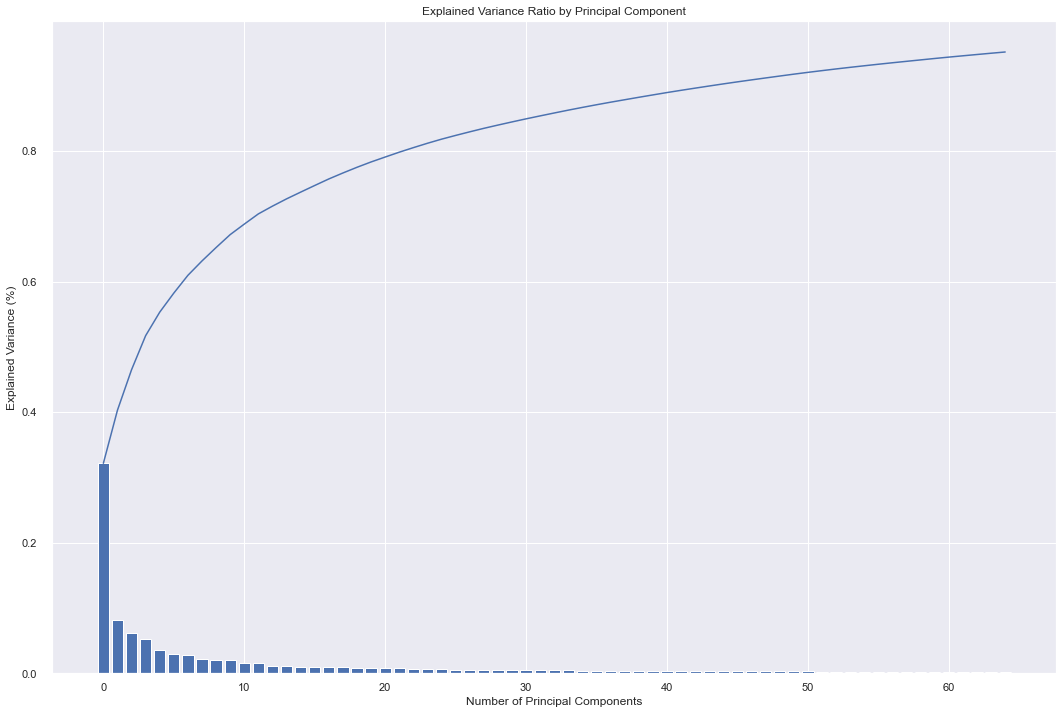

In [73]:
# Plot total explained variance for principal components
tick = np.arange(num_comps)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(18,12))
ax = plt.subplot(111)
sumvals = np.cumsum(vals)
ax.bar(tick, vals)
ax.plot(tick, sumvals)

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Explained Variance (%)")
plt.title("Explained Variance Ratio by Principal Component")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

I decided to loop through the possible number of principal components until I found a count that explained 95% of the variance. This reduced the number of dimensions by 83% (from 375 to 65).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [74]:
def map_pca_weights(dataset, dim, n_feats):
    """ 
    print top 25 weights for given component (n_comp)
    plot features with most absolute variance for given component (n_comp)
    """

    # get features names from dataset
    feat_names = dataset.columns.values

    # create dictionary with features and weights
    pca_map_weights = {}
    for cnt, feat in enumerate(feat_names):
        pca_map_weights[feat] = pca.components_[dim][cnt]

    sorted_weights = sorted(pca_map_weights.items(), key=operator.itemgetter(1), reverse=True)

    # print top n weights
    print(f'Top {n_feats} Features:')
    for i in range(0, n_feats):
        print(sorted_weights[i])
    
    # print bottom n weights
    l = len(sorted_weights)
    n = l - n_feats
    print(f'\nBottom {n_feats} Features:')
    for i in range(n, l):
        print(sorted_weights[i])
    print()

    # create dataframe from dictionary
    df = pd.DataFrame.from_dict(sorted_weights)
    df = pd.concat([df.head(n_feats), df.tail(n_feats)])
    df.columns = ['feature', 'weight']
    
    # return plot of features with most absolute variance
    return px.bar(
        df, x='feature', y='weight',
        color='weight', color_continuous_scale=px.colors.sequential.YlGnBu,
        labels = {'weight': 'Weight', 'feature': 'Features'},
        height=450, width=650
    )

In [75]:
# Map weights for the first principal component to corresponding feature names.
map_pca_weights(azdias, 1, 5)

Top 5 Features:
('LP_STATUS_FEIN_5.0', 0.3235566452758202)
('GFK_URLAUBERTYP_5.0', 0.31734477386457643)
('RETOURTYP_BK_S_3.0', 0.3014489842732861)
('LP_STATUS_GROB_2.0', 0.30035851103629413)
('CJT_GESAMTTYP_6.0', 0.29391416770246387)

Bottom 5 Features:
('LP_STATUS_FEIN_1.0', -0.11047406554645563)
('RETOURTYP_BK_S_5.0', -0.12677929007431646)
('LP_STATUS_GROB_1.0', -0.19320405756084977)
('LP_FAMILIE_FEIN_1.0', -0.19735800212777815)
('LP_FAMILIE_GROB_1.0', -0.19735800212777815)



In [76]:
# Map weights for the second principal component to corresponding feature names.
map_pca_weights(azdias, 2, 5)

Top 5 Features:
('ANREDE_KZ_2.0', 0.39285605848222904)
('SEMIO_VERT_4.0', 0.19511371390278381)
('SEMIO_KRIT_7.0', 0.18006524935894905)
('SEMIO_DOM_6.0', 0.17997218553398084)
('HEALTH_TYP_2.0', 0.15403303618104044)

Bottom 5 Features:
('SEMIO_MAT_6.0', -0.14982131105934648)
('SEMIO_SOZ_3.0', -0.1498657555884917)
('SEMIO_VERT_7.0', -0.18006524935894905)
('SEMIO_FAM_6.0', -0.20983023983385668)
('ANREDE_KZ_1.0', -0.39285605848222904)



In [77]:
# Map weights for the third principal component to corresponding feature names
map_pca_weights(azdias, 3, 5)

Top 5 Features:
('SEMIO_LUST_2.0', 0.2178352862906943)
('SEMIO_PFLICHT_5.0', 0.18157722822665542)
('PRAEGENDE_JUGENDJAHRE_DECADE_90.0', 0.1649213730097356)
('FINANZ_UNAUFFAELLIGER_5.0', 0.16419742527547146)
('SEMIO_DOM_2.0', 0.13548332563031906)

Bottom 5 Features:
('FINANZTYP_2.0', -0.16414840782201173)
('FINANZ_VORSORGER_5.0', -0.16767655237162496)
('SEMIO_PFLICHT_4.0', -0.1815898400590127)
('SEMIO_LUST_5.0', -0.19061419855528877)
('ZABEOTYP_3.0', -0.22157428989202205)



### Discussion 2.3: Interpret Principal Components

- The first component appears to be driven by a mix of different features. The most impactful are all loosely related to status (e.g. building location/type, academic title holders, number of households, distance to urban center).
- The second component is influenced by a combination of personality and financial features.
- The third component is primarily driven by personality features.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

> Over a number of different cluster counts, run k-means clustering on the data and compute the average within-cluster distances.

In [78]:
# run k-means clustering over a number of different cluster counts
scores = []
clusters = np.arange(1,21)
start = time.time()

for c in clusters:
    model = KMeans(c)
    model.fit(azdias_pca)
    score = round(abs(model.score(azdias_pca)), 2)
    scores.append(score)
    print(f'Score for {c} clusters: {score}')

end = time.time()
print(f'\nTotal time to score: {end - start:.2f} seconds.')

Score for 1 clusters: 1237929.36
Score for 2 clusters: 843505.96
Score for 3 clusters: 737533.25
Score for 4 clusters: 664743.04
Score for 5 clusters: 616866.91
Score for 6 clusters: 574876.34
Score for 7 clusters: 535787.82
Score for 8 clusters: 505670.87
Score for 9 clusters: 482927.64
Score for 10 clusters: 462376.28
Score for 11 clusters: 444284.79
Score for 12 clusters: 436444.02
Score for 13 clusters: 431521.48
Score for 14 clusters: 420944.1
Score for 15 clusters: 416221.96
Score for 16 clusters: 406143.27
Score for 17 clusters: 401774.86
Score for 18 clusters: 395889.89
Score for 19 clusters: 390796.39
Score for 20 clusters: 387922.94

Total time to score: 27.66 seconds.


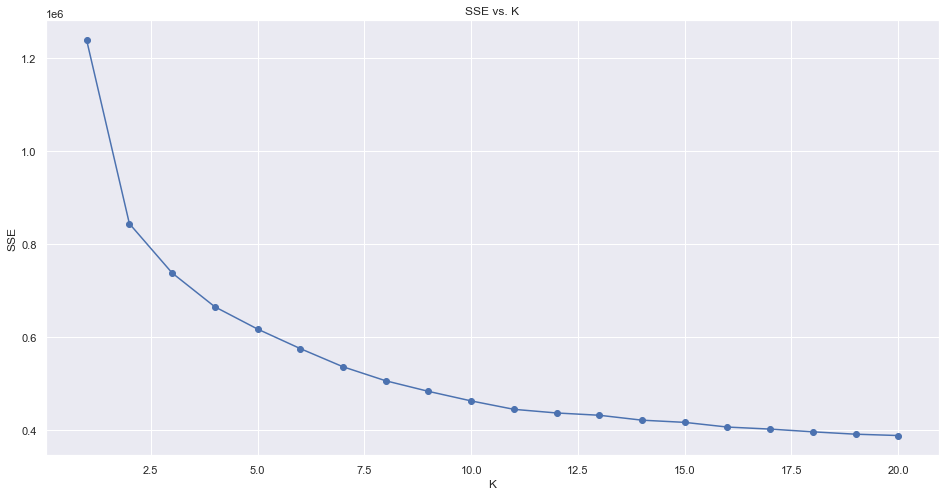

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
plt.figure(figsize=(16,8))
plt.plot(clusters, scores, marker='o');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.show()

> Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.

In [80]:
# refit k-means model with selected number of clusters
final_model = KMeans(12)
final_model.fit(azdias_pca)

azdias_preds = final_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

In this section, I fit and scored KMeans using the PCA-transformed dataset. I ran the model using 1 through 20 clusters, and the resulting score is calculated as the distance between records and their corresponding center-point. As the number of clusters increases, the distances between centroid and data points (along with the scores) decrease. 

To determine how many clusters was appropriate for the final model, I created a chart to visualize the scores for each iteration of the model run in the previous block. Although there isn't a clear 'elbow' in the chart, the scores start to smooth out around 12 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [81]:
# Load in the customer demographics data.
customers_og = pd.read_csv('udacity_customers_subset.csv', delimiter=';')

> Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.

In [82]:
# preprocess/feature transformation
customers = clean_data(customers_og)

New variables for PRAEGENDE_JUGENDJAHRE have been created: PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MOVEMENT
New variables for CAMEO_INTL_2015 have been created: CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFESTAGE

Features with data type mixed: 
 ['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']

Values for ANZ_PERSONEN have been grouped...
Values for ANZ_TITEL have been grouped...
Values for ANZ_HAUSHALTE_AKTIV have been grouped...
Values for ANZ_HH_TITEL have been grouped...
Values for MIN_GEBAEUDEJAHR have been grouped...
Values for KBA13_ANZAHL_PKW have been grouped...

Added 80 columns to dataframe:
['ALTERSKATEGORIE_GROB_9.0', 'ANZ_HAUSHALTE_AKTIV_0.0', 'ANZ_HAUSHALTE_AKTIV_15.0', 'ANZ_HH_TITEL_1.0', 'ANZ_HH_TITEL_2.0', 'ANZ_PERSONEN_10.0', 'ANZ_TITEL_3.0', 'ANZ_TITEL_4.0', 'ANZ_TITEL_5.0', 'ANZ_TITEL_10.0', 'ARBEIT_5.0', 'BALLRAUM_5.0', 'CAMEO_INTL_2015_LIFESTAGE_2.0', 'CAMEO_INTL_2015_LIFESTAGE_4.0', 'CAM

In [83]:
# check for NaN values
customers.isnull().sum().sum()

0

In [84]:
# feature scaling
customers_std = scaler.transform(customers)
print(customers_std.shape)

(49939, 375)


In [85]:
# pca
customers_pca = pca.transform(customers_std)
print(customers_pca.shape)

(49939, 65)


/Users/ajp/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [86]:
# cluster predictions
customers_preds = final_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

> Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

/Users/ajp/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/ajp/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



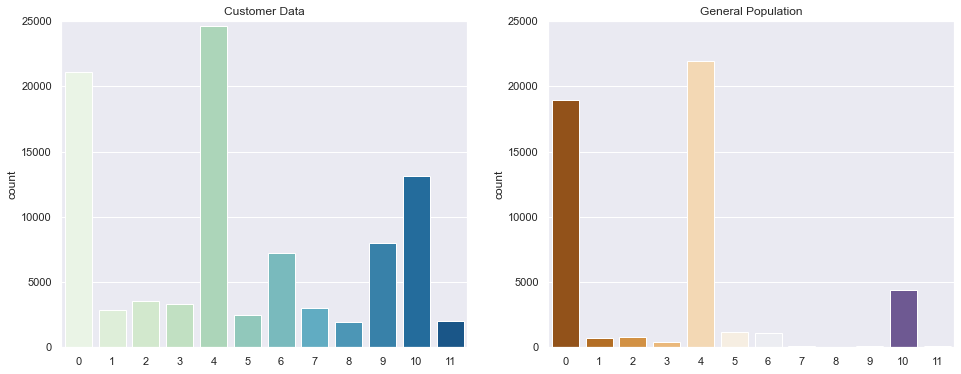

In [87]:
# plot proportions for customer data and general population (azdias)
fig = plt.figure(figsize=(16,6))
fig.tight_layout()
y = 25000

ax1 = fig.add_subplot(121)
ax1.title.set_text('Customer Data')
ax1.set(ylim=(0, y))
sns.countplot(azdias_preds, palette = 'GnBu')

ax2 = fig.add_subplot(122)
ax2.title.set_text('General Population')
ax2.set(ylim=(0, y))
sns.countplot(customers_preds, palette = 'PuOr')

plt.show()

In [88]:
def get_centroids(cluster_num):
    """ prints top and bottom 5 principal components by pca weight """
    
    centroid = final_model.cluster_centers_[cluster_num]
    df = pd.DataFrame(centroid,columns=['pca_weights'])
    df = df.reindex(df.sort_values('pca_weights',ascending=False).index)
    print(f'--- Top 5 Principal Components ---\n{df.head()}')
    print(f'\n--- Bottom 5 Principal Components ---\n{df.tail()}')

> What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

Cluster-11 appears to be the most overrepresented in the customer data compared to the general population. To find out what kinds of people are part of this cluster, I'll extract the Principal Components (PC) with the most significant impact on Cluster-11. Then I'll take a closer look at some of those PCs.

In [89]:
# Check PCA weights of Principal Components for Cluster-8
get_centroids(11)

--- Top 5 Principal Components ---
   pca_weights
0     2.687821
6     2.050843
2     1.662405
3     1.433669
7     1.201408

--- Bottom 5 Principal Components ---
    pca_weights
5     -0.457762
20    -0.465067
4     -0.872934
1     -0.907756
9     -1.091373


In [90]:
# PC-1 had the largest positive impact on the PCA weights for Cluster-8
map_pca_weights(azdias, 4, 3)

Top 3 Features:
('ALTERSKATEGORIE_GROB_3.0', 0.523675618366617)
('SEMIO_LUST_1.0', 0.1532885110286666)
('FINANZ_VORSORGER_4.0', 0.15063262489079196)

Bottom 3 Features:
('SEMIO_TRADV_1.0', -0.15652603194194664)
('ALTERSKATEGORIE_GROB_1.0', -0.17669510870503582)
('ALTERSKATEGORIE_GROB_2.0', -0.19041955613420142)



The features that are positively correlated with Principal Component 4 are:
- Customers with an estimated age between 46 and 60 years old (ALTERSKATEGORIE_GROB_3.0)
- Customers with the highest affinity for the personality typology: sensual-minded (SEMIO_LUST_1.0)
- Customers that have a low affinity for the financial typology: be prepared (FINANZ_VORSORGER_4.0)

The features that are negatively correlated with Principal Component 4 are:
- Customers with the highest affinity for the personality typology: traditional-minded (SEMIO_TRADV_1.0)
- Customers with an estimated age of less than 45 years old (ALTERSKATEGORIE_GROB_1.0 & ALTERSKATEGORIE_GROB_2.0)

In [91]:
# PC-0 had the largest negative impact on the PCA weights for Cluster-8
map_pca_weights(azdias, 1, 3)

Top 3 Features:
('LP_STATUS_FEIN_5.0', 0.3235566452758202)
('GFK_URLAUBERTYP_5.0', 0.31734477386457643)
('RETOURTYP_BK_S_3.0', 0.3014489842732861)

Bottom 3 Features:
('LP_STATUS_GROB_1.0', -0.19320405756084977)
('LP_FAMILIE_FEIN_1.0', -0.19735800212777815)
('LP_FAMILIE_GROB_1.0', -0.19735800212777815)



The features that are positively correlated with Principal Component 1 are:
- Customers with social status: minimalistic high-income earners (LP_STATUS_FEIN_5.0)
- Customers with vacation habits: Nature fans (GFK_URLAUBERTYP_5.0)
- Customers with return type: incentive-receptive Normal-Returner (RETOURTYP_BK_S_3.0)

The features that are negatively correlated with Principal Component 1 are:
- Customers with social status: low-income earners (LP_STATUS_GROB_1.0
- Customers with family type: single (LP_FAMILIE_FEIN_1.0 & LP_FAMILIE_GROB_1.0)

> What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

Cluster-0 appears to be the most underrepresented in the customer data compared to the general population. To find out what kinds of people are part of this cluster, I'll extract the Principal Components (PC) with the most significant impact on Cluster-0. Then I'll take a closer look at some of those PCs.

In [92]:
# Check PCA weights of Principal Components for Cluster-1
get_centroids(0)

--- Top 5 Principal Components ---
    pca_weights
1      0.806791
7      0.389837
3      0.201572
10     0.163883
20     0.038003

--- Bottom 5 Principal Components ---
   pca_weights
9    -0.205013
8    -0.232154
2    -0.313606
6    -0.342650
0    -1.398382


In [93]:
# PC-1 had the largest positive impact on the PCA weights for Cluster-1
map_pca_weights(azdias, 1, 3)

Top 3 Features:
('LP_STATUS_FEIN_5.0', 0.3235566452758202)
('GFK_URLAUBERTYP_5.0', 0.31734477386457643)
('RETOURTYP_BK_S_3.0', 0.3014489842732861)

Bottom 3 Features:
('LP_STATUS_GROB_1.0', -0.19320405756084977)
('LP_FAMILIE_FEIN_1.0', -0.19735800212777815)
('LP_FAMILIE_GROB_1.0', -0.19735800212777815)



The features that are positively correlated with Principal Component 1 are:
- Customers with social status: minimalistic high-income earners (LP_STATUS_FEIN_5.0)
- Customers with vacation habits: Nature fans (GFK_URLAUBERTYP_5.0)
- Customers with return type: incentive-receptive Normal-Returner (RETOURTYP_BK_S_3.0)

The features that are negatively correlated with Principal Component 1 are:
- Customers with social status: low-income earners (LP_STATUS_GROB_1.0
- Customers with family type: single (LP_FAMILIE_FEIN_1.0 & LP_FAMILIE_GROB_1.0)

In [94]:
# PC-0 had the largest negative impact on the PCA weights for Cluster-1
map_pca_weights(azdias, 0, 3)

Top 3 Features:
('ANZ_TITEL_0.0', 0.18506448158702837)
('SOHO_KZ_0.0', 0.1842357672824032)
('NATIONALITAET_KZ_1.0', 0.15826050009461212)

Bottom 3 Features:
('SEMIO_VERT_1.0', -0.1717019005707613)
('FINANZTYP_4.0', -0.1777372327909146)
('HH_EINKOMMEN_SCORE_2.0', -0.17908653511308933)



The features that are positively correlated with Principal Component 0 are:
- Customers with zero professional academic title holders in the household (ANZ_TITEL_0.0)
- Customers with no small office/home office (SOHO_KZ_0.0)
- Customers with a German-sounding nationality based on given name analysis (NATIONALITAET_KZ_1.0)

The features that are negatively correlated with Principal Component 0 are:
- Customers with the highest affinity for the personality typology: traditional-minded (SEMIO_TRADV_1.0)
- Customers whose most descriptive financial type is: be prepared (FINANZTYP_4.0)
- Customers with an estimated household net income of: very high income (HH_EINKOMMEN_SCORE_2.0)

### Discussion 3.3: Compare Customer Data to Demographics Data

There are a few customer segments that stand out as being relatively popular with this mail-order company: estimated age 46-60 (ALTERSKATEGORIE_GROB_3.0), sensual-minded (SEMIO_LUST_1.0), financially unprepared (FINANZ_VORSORGER_4.0).

There are also a few customer segments that are relatively unpopular with this mail-order company: minimalistic high-income earner(LP_STATUS_FEIN_5.0), nature fans (GFK_URLAUBERTYP_5.0), and incentive-receptive (RETOURTYP_BK_S_3.0).

In [ ]:
''' ____                           ______                __
   / __ )_________  ____  ____ ___/_  __/___  ____ _____/ /
  / __  / ___/ __ \/ __ \/_  // _ \/ / / __ \/ __ `/ __  / 
 / /_/ / /  / /_/ / / / / / //  __/ / / /_/ / /_/ / /_/ /  
/_____/_/   \____/_/ /_/ /___|___/_/  \____/\__,_/\__,_/ '''